In [1]:
import pandas as pd
import numpy as np
import os, random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files
import pandas as pd, os

uploaded = files.upload()

BASE_DIR = '/content'
TRAIN_PATH = os.path.join(BASE_DIR, 'train.csv')
TEST_PATH = os.path.join(BASE_DIR, 'test.csv')
BUILD_PATH = os.path.join(BASE_DIR, 'building_info.csv')
SAMPLE_SUB = os.path.join(BASE_DIR, 'sample_submission.csv')

Saving building_info.csv to building_info.csv
Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
building_info = pd.read_csv(BUILD_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB)

In [4]:
#한글 폰트 설정
!pip install koreanize-matplotlib > /dev/null
import koreanize_matplotlib
plt.rc('axes', unicode_minus=False)

In [5]:
#데이터 병합
merged = train.merge(building_info, on="건물번호", how="left")

In [6]:
df = merged.copy()

# 냉방면적 비율
df['냉방면적비율'] = df['냉방면적(m2)'] / df['연면적(m2)'].replace(0, np.nan)
df['냉방면적비율'] = df['냉방면적비율'].fillna(0)

# 태양광 / ESS 유무 플래그
df['has_태양광'] = (df['태양광용량(kW)'].replace('-', 0).astype(float) > 0).astype(int)
df['has_ESS']   = (df['ESS저장용량(kWh)'].replace('-', 0).astype(float) > 0).astype(int)

/tmp/ipython-input-1585017057.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = df.groupby('냉방면적비율_bin2')['전력소비량(kWh)'].mean().reset_index()


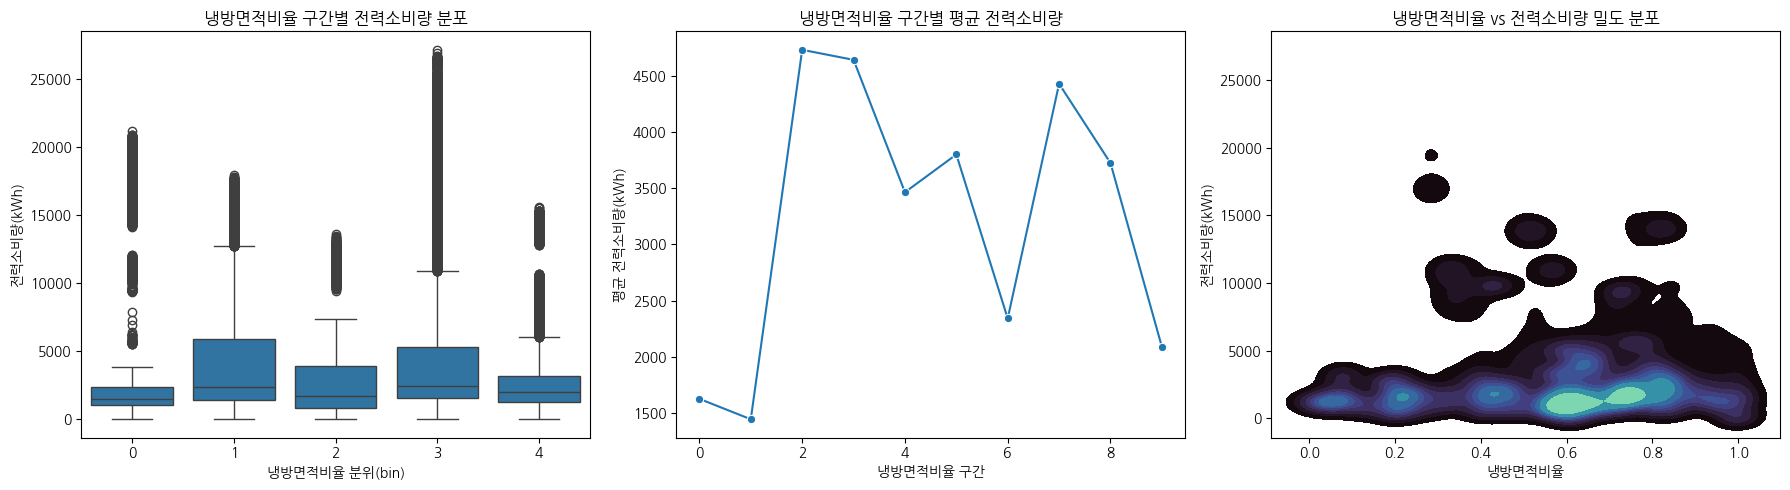

In [7]:
#냉방면적비율
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Boxplot (분위수 구간)
df['냉방면적비율_bin'] = pd.qcut(df['냉방면적비율'], q=5, labels=False)
sns.boxplot(data=df, x='냉방면적비율_bin', y='전력소비량(kWh)', ax=axes[0])
axes[0].set_title("냉방면적비율 구간별 전력소비량 분포")
axes[0].set_xlabel("냉방면적비율 분위(bin)")
axes[0].set_ylabel("전력소비량(kWh)")

# Lineplot (구간별 평균)
df['냉방면적비율_bin2'] = pd.cut(df['냉방면적비율'], bins=10)
mean_by_bin = df.groupby('냉방면적비율_bin2')['전력소비량(kWh)'].mean().reset_index()
sns.lineplot(data=mean_by_bin, x=mean_by_bin.index, y='전력소비량(kWh)', marker='o', ax=axes[1])
axes[1].set_title("냉방면적비율 구간별 평균 전력소비량")
axes[1].set_xlabel("냉방면적비율 구간")
axes[1].set_ylabel("평균 전력소비량(kWh)")

# KDE Heatmap
sns.kdeplot(
    data=df, x="냉방면적비율", y="전력소비량(kWh)",
    fill=True, cmap="mako", thresh=0.05, ax=axes[2]
)
axes[2].set_title("냉방면적비율 vs 전력소비량 밀도 분포")
axes[2].set_xlabel("냉방면적비율")
axes[2].set_ylabel("전력소비량(kWh)")

plt.tight_layout()
plt.show()

In [8]:
#태양광 유무별 평균 전력소비량
sns.barplot(data=df, x='has_태양광', y='전력소비량(kWh)', estimator=np.mean, ax=axes[0])
axes[0].set_title("태양광 유무별 평균 전력소비량")

#ESS 유무별 평균 전력소비량
sns.barplot(data=df, x='has_ESS', y='전력소비량(kWh)', estimator=np.mean, ax=axes[1])
axes[1].set_title("ESS 유무별 평균 전력소비량")

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-1318265248.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped.values, y=grouped.index, palette="viridis")


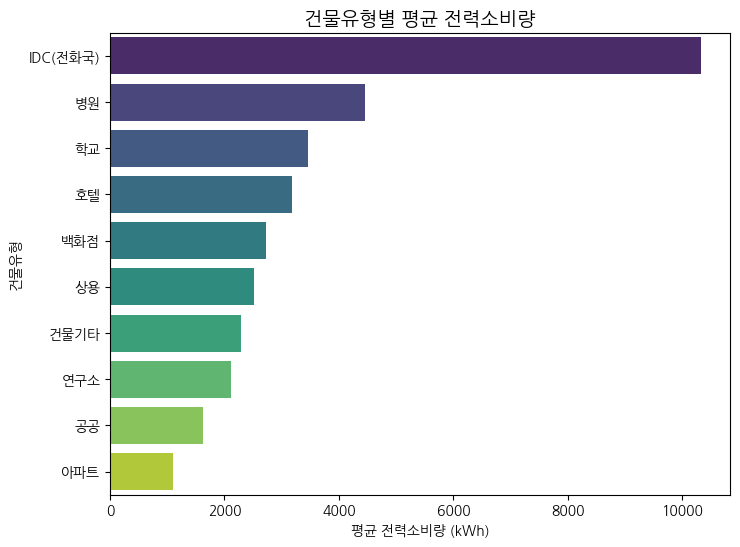

In [9]:
grouped = merged.groupby("건물유형")["전력소비량(kWh)"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=grouped.values, y=grouped.index, palette="viridis")
plt.title("건물유형별 평균 전력소비량", fontsize=14)
plt.xlabel("평균 전력소비량 (kWh)")
plt.ylabel("건물유형")
plt.show()

/tmp/ipython-input-363463089.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="건물유형", y="전력소비량(kWh)", data=merged, palette="Set2")


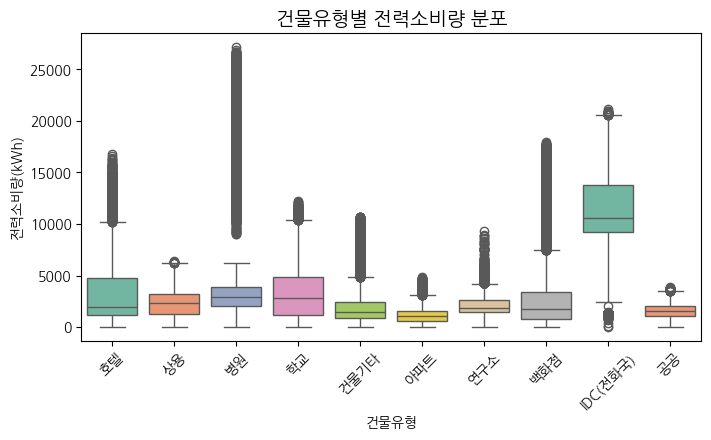

In [10]:
#건물유형별 전력소비량 분포 -- 이상치 확인
plt.figure(figsize=(8,4))
sns.boxplot(x="건물유형", y="전력소비량(kWh)", data=merged, palette="Set2")
plt.xticks(rotation=45)
plt.title("건물유형별 전력소비량 분포", fontsize=14)
plt.show()

/tmp/ipython-input-1270645988.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_norm.values, y=grouped_norm.index, palette="mako")


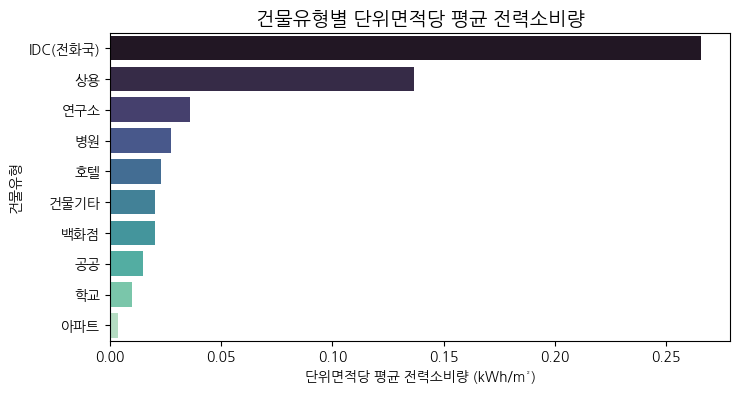

In [11]:
#단위면적당 전력소비량
merged["단위면적당소비량"] = merged["전력소비량(kWh)"] / merged["연면적(m2)"]

grouped_norm = merged.groupby("건물유형")["단위면적당소비량"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=grouped_norm.values, y=grouped_norm.index, palette="mako")
plt.title("건물유형별 단위면적당 평균 전력소비량", fontsize=14)
plt.xlabel("단위면적당 평균 전력소비량 (kWh/m²)")
plt.ylabel("건물유형")
plt.show()

(1)

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [14]:
uploaded = files.upload()

BASE_DIR = '/content'
TRAIN_PATH = os.path.join(BASE_DIR, 'train.csv')
TEST_PATH = os.path.join(BASE_DIR, 'test.csv')
BUILD_PATH = os.path.join(BASE_DIR, 'building_info.csv')
SAMPLE_SUB = os.path.join(BASE_DIR, 'sample_submission.csv')

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
binfo = pd.read_csv(BUILD_PATH)
sub   = pd.read_csv(SAMPLE_SUB)

train_df = train.copy()
test_df  = test.copy()

Saving building_info.csv to building_info (1).csv
Saving sample_submission.csv to sample_submission (1).csv
Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [15]:
train_df['datetime'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
test_df['datetime']  = pd.to_datetime(test_df['일시'],  format='%Y%m%d %H')

for df in [train_df, test_df]:
    df['month'] = df['datetime'].dt.month
    df['day']   = df['datetime'].dt.day
    df['hour']  = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['weekday']>=5).astype(int)
    df['hour_sin']  = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos']  = np.cos(2*np.pi*df['hour']/24)
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['weekday_sin'] = np.sin(2*np.pi*df['weekday']/7)
    df['weekday_cos'] = np.cos(2*np.pi*df['weekday']/7)

In [17]:
def clip_iqr(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

for col in ['강수량(mm)','풍속(m/s)']:
    train_df[col] = clip_iqr(train_df[col])
    test_df[col]  = clip_iqr(test_df[col])

In [18]:
binfo_proc = binfo.copy()
for col in ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']:
    binfo_proc[col] = binfo_proc[col].replace('-', 0)
    binfo_proc[col] = pd.to_numeric(binfo_proc[col], errors='coerce').fillna(0)

if '건물유형' in binfo_proc.columns:
    binfo_proc = pd.get_dummies(binfo_proc, columns=['건물유형'], prefix='유형')

train_df = train_df.merge(binfo_proc, on='건물번호', how='left')
test_df  = test_df.merge(binfo_proc,  on='건물번호', how='left')

In [19]:
feature_cols = ['기온(°C)','강수량(mm)','풍속(m/s)','습도(%)',
                'hour_sin','hour_cos','month_sin','month_cos','weekday_sin','weekday_cos',
                'is_weekend']
feature_cols += [c for c in binfo_proc.columns if c!='건물번호']

X_train_df = train_df[feature_cols]
X_test_df = test_df[feature_cols]

In [20]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_df)
X_test  = x_scaler.transform(X_test_df)

y_scaler = StandardScaler()
y_train_raw = train_df['전력소비량(kWh)'].values.reshape(-1,1)
y_train_log = np.log1p(y_train_raw)
y_train     = y_scaler.fit_transform(y_train_log).ravel()

train_df = train_df.sort_values(['건물번호','datetime']).reset_index(drop=True)

split_time = train_df['datetime'].quantile(0.8)
tr_mask = train_df['datetime'] <= split_time
va_mask = train_df['datetime'] > split_time

df_tr = train_df.loc[tr_mask].reset_index(drop=True)
df_va = train_df.loc[va_mask].reset_index(drop=True)

X_tr_base = X_train[tr_mask.values]
y_tr_base = y_train[tr_mask.values]
X_va_base = X_train[va_mask.values]
y_va_base = y_train[va_mask.values]

In [21]:
LOOKBACK = 24
HORIZON  = 1

def build_sequences(df_subset, X_subset, y_subset, lookback=24, horizon=1):
    xs, ys = [], []
    for bnum, g in df_subset.groupby('건물번호', sort=True):
        idx = g.index.values
        for i in range(len(idx) - lookback - horizon + 1):
            seq_idx = idx[i:i+lookback]
            tgt_idx = idx[i+lookback + horizon - 1]
            xs.append(X_subset[seq_idx])
            ys.append(y_subset[tgt_idx])
    return np.array(xs), np.array(ys)

X_tr, y_tr = build_sequences(df_tr, X_tr_base, y_tr_base, lookback=LOOKBACK, horizon=HORIZON)
X_va, y_va = build_sequences(df_va, X_va_base, y_va_base, lookback=LOOKBACK, horizon=HORIZON)

print("Train seq:", X_tr.shape, "Valid seq:", X_va.shape)

Train seq: (160800, 24, 26) Valid seq: (38400, 24, 26)


In [22]:
def smape_tf(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1,))
    y_pred = tf.reshape(y_pred, (-1,))
    denom = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + 1e-7
    return tf.reduce_mean(tf.abs(y_true - y_pred) / denom)

es  = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
rlr = keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5)

In [23]:
print("\n--- 1. LSTM 모델 학습 시작 ---")
model_lstm = keras.Sequential([
    layers.Input(shape=(LOOKBACK, X_tr.shape[-1])),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])
model_lstm.compile(optimizer=keras.optimizers.Adam(1e-3),
                   loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae'), smape_tf])
hist_lstm = model_lstm.fit(X_tr, y_tr,
                           validation_data=(X_va, y_va),
                           epochs=50, batch_size=256,
                           callbacks=[es, rlr], verbose=1)



--- 1. LSTM 모델 학습 시작 ---
Epoch 1/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - loss: 0.4228 - mae: 0.4351 - smape_tf: 0.9209 - val_loss: 0.2378 - val_mae: 0.2858 - val_smape_tf: 0.7123 - learning_rate: 0.0010
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 72s 54ms/step - loss: 0.1889 - mae: 0.2781 - smape_tf: 0.6839 - val_loss: 0.1850 - val_mae: 0.2462 - val_smape_tf: 0.6598 - learning_rate: 0.0010
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - loss: 0.1363 - mae: 0.2332 - smape_tf: 0.5979 - val_loss: 0.1312 - val_mae: 0.2183 - val_smape_tf: 0.6183 - learning_rate: 0.0010
Epoch 4/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.1034 - mae: 0.2028 - smape_tf: 0.5451 - val_loss: 0.0786 - val_mae: 0.1777 - val_smape_tf: 0.5422 - learning_rate: 0.0010
Epoch 5/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 0.0748 - mae: 0.1774 - smape_tf: 0.5018 - val_loss: 0.0802 - val_mae: 0.1692 - val_smape_tf: 0.5160 - learning_rate: 0.0010
Epoch 6/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 32s 

In [24]:
print("\n--- 2. GRU 모델 학습 시작 ---")
model_gru = keras.Sequential([
    layers.Input(shape=(LOOKBACK, X_tr.shape[-1])),
    layers.GRU(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])
model_gru.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae'), smape_tf])
hist_gru = model_gru.fit(X_tr, y_tr,
                         validation_data=(X_va, y_va),
                         epochs=50, batch_size=256,
                         callbacks=[es, rlr], verbose=1)


--- 2. GRU 모델 학습 시작 ---
Epoch 1/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - loss: 0.4587 - mae: 0.4696 - smape_tf: 0.9593 - val_loss: 0.2110 - val_mae: 0.2930 - val_smape_tf: 0.7447 - learning_rate: 0.0010
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - loss: 0.2008 - mae: 0.2949 - smape_tf: 0.7075 - val_loss: 0.1865 - val_mae: 0.2680 - val_smape_tf: 0.6906 - learning_rate: 0.0010
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.1600 - mae: 0.2577 - smape_tf: 0.6291 - val_loss: 0.1319 - val_mae: 0.2327 - val_smape_tf: 0.6524 - learning_rate: 0.0010
Epoch 4/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - loss: 0.1212 - mae: 0.2245 - smape_tf: 0.5764 - val_loss: 0.0917 - val_mae: 0.2007 - val_smape_tf: 0.5959 - learning_rate: 0.0010
Epoch 5/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - loss: 0.1072 - mae: 0.2119 - smape_tf: 0.5562 - val_loss: 0.0671 - val_mae: 0.1728 - val_smape_tf: 0.5476 - learning_rate: 0.0010
Epoch 6/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 37s 5

In [25]:
def smape_np(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + 1e-7
    return np.mean(np.abs(y_true - y_pred) / denom)

y_va_true_scaled = y_va.reshape(-1,1)
y_va_true_log = y_scaler.inverse_transform(y_va_true_scaled)
y_va_true = np.expm1(y_va_true_log).ravel()

y_va_pred_scaled_lstm = model_lstm.predict(X_va).reshape(-1,1)
y_va_pred_log_lstm = y_scaler.inverse_transform(y_va_pred_scaled_lstm)
y_va_pred_lstm = np.expm1(y_va_pred_log_lstm).ravel()

y_va_pred_scaled_gru = model_gru.predict(X_va).reshape(-1,1)
y_va_pred_log_gru = y_scaler.inverse_transform(y_va_pred_scaled_gru)
y_va_pred_gru = np.expm1(y_va_pred_log_gru).ravel()

y_va_pred_ensemble = (y_va_pred_lstm + y_va_pred_gru) / 2.0

smp_lstm = smape_np(y_va_true, y_va_pred_lstm)
smp_gru = smape_np(y_va_true, y_va_pred_gru)
smp_ensemble = smape_np(y_va_true, y_va_pred_ensemble)

results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Ensemble'],
    'SMAPE (%)': [smp_lstm * 100, smp_gru * 100, smp_ensemble * 100]
})
results_df = results_df.set_index('Model')
print("\n[모델별 SMAPE 성능 비교]")
print(results_df.round(4))

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

[모델별 SMAPE 성능 비교]
          SMAPE (%)
Model              
LSTM        12.1229
GRU         11.7278
Ensemble    11.0922


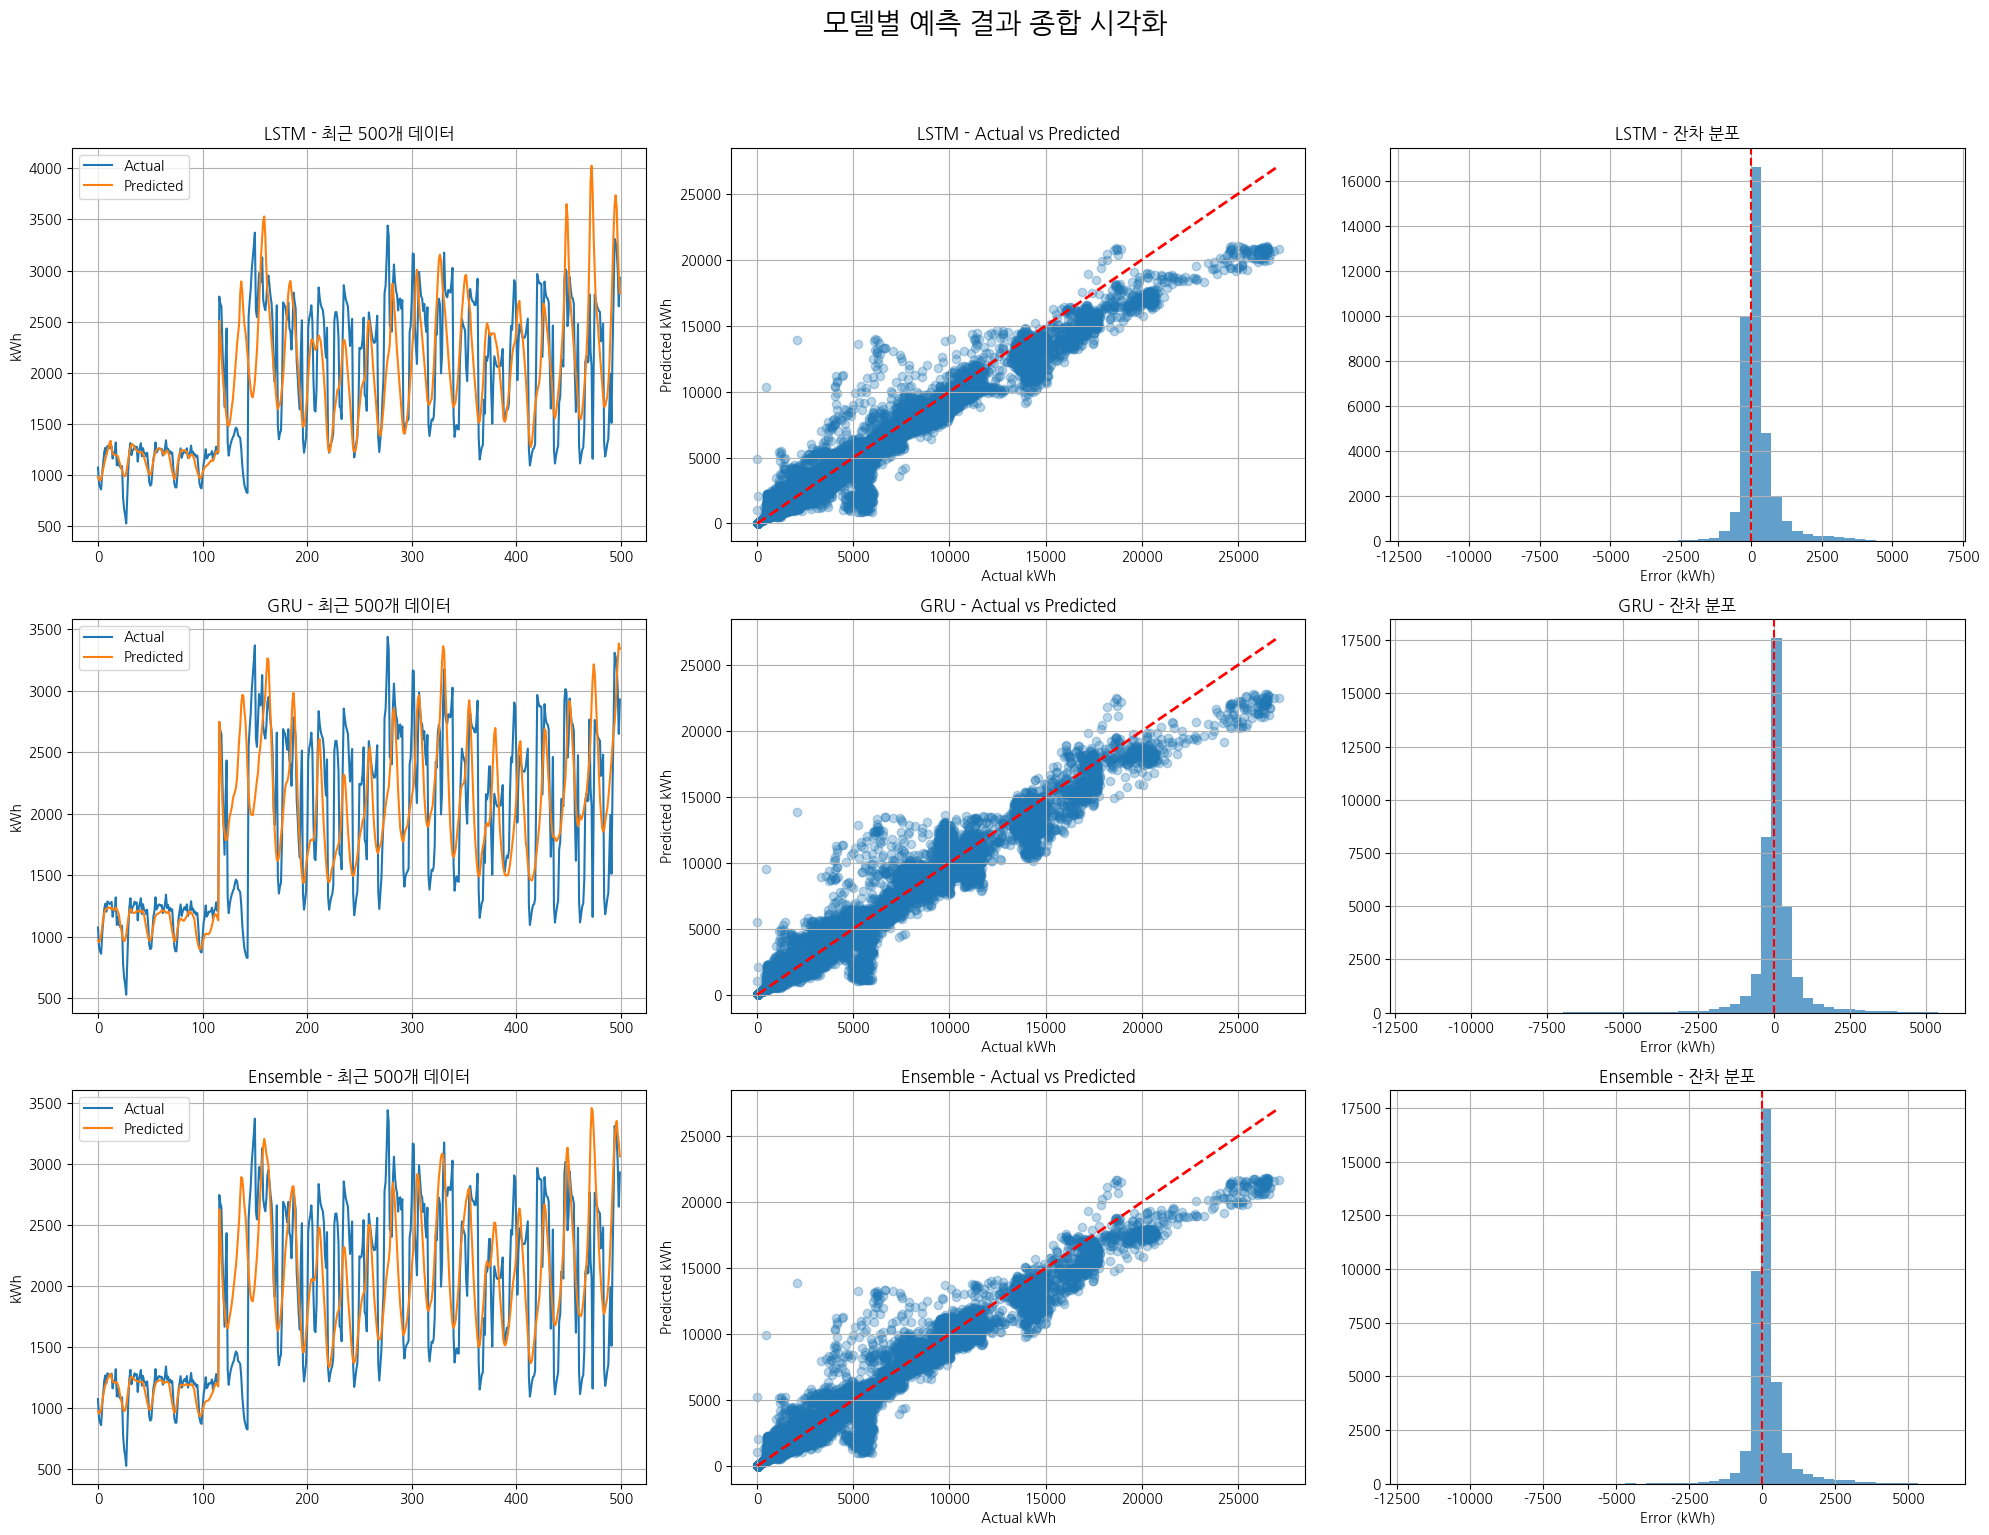

In [26]:
def plot_all_results(ax_row, title, y_true, y_pred):
    n = min(500, len(y_true))
    residuals = y_true - y_pred

    ax_row[0].plot(y_true[-n:], label='Actual')
    ax_row[0].plot(y_pred[-n:], label='Predicted')
    ax_row[0].set_title(f'{title} - 최근 {n}개 데이터')
    ax_row[0].set_ylabel('kWh')
    ax_row[0].legend()
    ax_row[0].grid(True)

    ax_row[1].scatter(y_true, y_pred, alpha=0.3)
    ax_row[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    ax_row[1].set_title(f'{title} - Actual vs Predicted')
    ax_row[1].set_xlabel('Actual kWh')
    ax_row[1].set_ylabel('Predicted kWh')
    ax_row[1].grid(True)

    ax_row[2].hist(residuals, bins=50, alpha=0.7)
    ax_row[2].axvline(0, color='red', linestyle='--')
    ax_row[2].set_title(f'{title} - 잔차 분포')
    ax_row[2].set_xlabel('Error (kWh)')
    ax_row[2].grid(True)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('모델별 예측 결과 종합 시각화', fontsize=20, y=1.02)

plot_all_results(axes[0], 'LSTM', y_va_true, y_va_pred_lstm)
plot_all_results(axes[1], 'GRU', y_va_true, y_va_pred_gru)
plot_all_results(axes[2], 'Ensemble', y_va_true, y_va_pred_ensemble)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

(2)

In [27]:
import pandas as pd
import numpy as np
import os, random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from google.colab import files
import pandas as pd, os

uploaded = files.upload()

BASE_DIR = '/content'
TRAIN_PATH = os.path.join(BASE_DIR, 'train.csv')
TEST_PATH = os.path.join(BASE_DIR, 'test.csv')
BUILD_PATH = os.path.join(BASE_DIR, 'building_info.csv')
SAMPLE_SUB = os.path.join(BASE_DIR, 'sample_submission.csv')

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
binfo = pd.read_csv(BUILD_PATH)
sub   = pd.read_csv(SAMPLE_SUB)

train_df = train.copy()
test_df  = test.copy()

train_df['datetime'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
test_df['datetime']  = pd.to_datetime(test_df['일시'],  format='%Y%m%d %H')

Saving building_info.csv to building_info (2).csv
Saving sample_submission.csv to sample_submission (2).csv
Saving test.csv to test (2).csv
Saving train.csv to train (2).csv


In [28]:
#시계열 특성 및 불쾌지수 생성
def calculate_discomfort_index(temp, humid):
    rh = humid / 100.0
    di = (9/5 * temp) - 0.55 * (1 - rh) * ((9/5 * temp) - 26) + 32
    return di

for df in [train_df, test_df]:
    df['month'] = df['datetime'].dt.month
    df['day']   = df['datetime'].dt.day
    df['hour']  = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['weekday']>=5).astype(int)
    df['hour_sin']  = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos']  = np.cos(2*np.pi*df['hour']/24)
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['weekday_sin'] = np.sin(2*np.pi*df['weekday']/7)
    df['weekday_cos'] = np.cos(2*np.pi*df['weekday']/7)
    df['불쾌지수'] = calculate_discomfort_index(df['기온(°C)'], df['습도(%)'])

In [29]:
# 이상치 처리
def clip_iqr(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

for col in ['강수량(mm)','풍속(m/s)']:
    train_df[col] = clip_iqr(train_df[col])
    test_df[col]  = clip_iqr(test_df[col])

In [30]:
# 건물 정보 파생 변수 생성 및 병합
binfo_proc = binfo.copy()

# 결측치/'-' 처리
for col in ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']:
    binfo_proc[col] = binfo_proc[col].replace('-', 0)
    binfo_proc[col] = pd.to_numeric(binfo_proc[col], errors='coerce').fillna(0)

# 파생 건물 특성 추가
binfo_proc['냉방비율'] = (binfo_proc['냉방면적(m2)'] / binfo_proc['연면적(m2)']).fillna(0)
binfo_proc['has_solar'] = (binfo_proc['태양광용량(kW)'] > 0).astype(int)
binfo_proc['has_ess']   = (binfo_proc['ESS저장용량(kWh)'] > 0).astype(int)
binfo_proc['has_pcs']   = (binfo_proc['PCS용량(kW)'] > 0).astype(int)
binfo_proc['solar_density'] = (binfo_proc['태양광용량(kW)'] / binfo_proc['연면적(m2)']).fillna(0)
binfo_proc['ess_density']   = (binfo_proc['ESS저장용량(kWh)'] / binfo_proc['연면적(m2)']).fillna(0)
binfo_proc['pcs_density']   = (binfo_proc['PCS용량(kW)'] / binfo_proc['연면적(m2)']).fillna(0)

# 건물유형 원-핫 인코딩
if '건물유형' in binfo_proc.columns:
    binfo_proc = pd.get_dummies(binfo_proc, columns=['건물유형'], prefix='유형')

In [31]:
# 기존 train/test에 병합
train_df = pd.merge(train_df, binfo_proc, on='건물번호', how='left')
test_df  = pd.merge(test_df,  binfo_proc, on='건물번호', how='left')

train_df = train_df.sort_values(['건물번호','datetime']).reset_index(drop=True)
test_df  = test_df.sort_values(['건물번호','datetime']).reset_index(drop=True)

In [32]:
# 최종 피처 선택
feature_cols = [
    '기온(°C)','강수량(mm)','풍속(m/s)','습도(%)','불쾌지수',
    'hour_sin','hour_cos','month_sin','month_cos',
    'weekday_sin','weekday_cos','is_weekend'
]
feature_cols += [c for c in binfo_proc.columns if c!='건물번호']

X_train_df = train_df[feature_cols]
X_test_df = test_df[feature_cols]

In [33]:
# NaN 값이 있는지 확인하고 0으로 채우기
X_train_df = X_train_df.fillna(0)
X_test_df = X_test_df.fillna(0)

In [34]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train_df)
X_test  = x_scaler.transform(X_test_df)

y_scaler = StandardScaler()
y_train_raw = train_df['전력소비량(kWh)'].values.reshape(-1,1)
y_train_log = np.log1p(y_train_raw)
y_train     = y_scaler.fit_transform(y_train_log).ravel()

In [35]:
# 학습/검증 데이터 분리 및 시퀀스 생성
train_df = train_df.sort_values(['건물번호','datetime']).reset_index(drop=True)

split_time = train_df['datetime'].quantile(0.8)
tr_mask = train_df['datetime'] <= split_time
va_mask = train_df['datetime'] > split_time

df_tr = train_df.loc[tr_mask].reset_index(drop=True)
df_va = train_df.loc[va_mask].reset_index(drop=True)

X_tr_base = X_train[tr_mask.values]
y_tr_base = y_train[tr_mask.values]
X_va_base = X_train[va_mask.values]
y_va_base = y_train[va_mask.values]

In [36]:
LOOKBACK = 24
HORIZON  = 1

def build_sequences(df_subset, X_subset, y_subset, lookback=24, horizon=1):
    xs, ys = [], []
    for bnum, g in df_subset.groupby('건물번호', sort=True):
        idx = g.index.values
        for i in range(len(idx) - lookback - horizon + 1):
            seq_idx = idx[i:i+lookback]
            tgt_idx = idx[i+lookback + horizon - 1]
            xs.append(X_subset[seq_idx])
            ys.append(y_subset[tgt_idx])
    return np.array(xs), np.array(ys)

X_tr, y_tr = build_sequences(df_tr, X_tr_base, y_tr_base, lookback=LOOKBACK, horizon=HORIZON)
X_va, y_va = build_sequences(df_va, X_va_base, y_va_base, lookback=LOOKBACK, horizon=HORIZON)

print("Train seq:", X_tr.shape, "Valid seq:", X_va.shape)

Train seq: (160800, 24, 34) Valid seq: (38400, 24, 34)


In [37]:
def smape_tf(y_true, y_pred):
    y_true = tf.reshape(y_true, (-1,))
    y_pred = tf.reshape(y_pred, (-1,))
    denom = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + 1e-7
    return tf.reduce_mean(tf.abs(y_true - y_pred) / denom)

es  = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
rlr = keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5)

In [38]:
print("\n--- 1. LSTM 모델 학습 시작 ---")
model_lstm = keras.Sequential([
    layers.Input(shape=(LOOKBACK, X_tr.shape[-1])),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])
model_lstm.compile(optimizer=keras.optimizers.Adam(1e-3),
                   loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae'), smape_tf])
hist_lstm = model_lstm.fit(X_tr, y_tr,
                           validation_data=(X_va, y_va),
                           epochs=50, batch_size=256,
                           callbacks=[es, rlr], verbose=1)


--- 1. LSTM 모델 학습 시작 ---
Epoch 1/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - loss: 0.3571 - mae: 0.3913 - smape_tf: 0.8681 - val_loss: 0.0752 - val_mae: 0.1935 - val_smape_tf: 0.5805 - learning_rate: 0.0010
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - loss: 0.0797 - mae: 0.1902 - smape_tf: 0.5335 - val_loss: 0.0526 - val_mae: 0.1525 - val_smape_tf: 0.5011 - learning_rate: 0.0010
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - loss: 0.0614 - mae: 0.1586 - smape_tf: 0.4673 - val_loss: 0.0462 - val_mae: 0.1366 - val_smape_tf: 0.4596 - learning_rate: 0.0010
Epoch 4/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - loss: 0.0545 - mae: 0.1449 - smape_tf: 0.4354 - val_loss: 0.0442 - val_mae: 0.1328 - val_smape_tf: 0.4470 - learning_rate: 0.0010
Epoch 5/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - loss: 0.0509 - mae: 0.1380 - smape_tf: 0.4180 - val_loss: 0.0467 - val_mae: 0.1376 - val_smape_tf: 0.4690 - learning_rate: 0.0010
Epoch 6/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 36s 

In [39]:
print("\n--- 2. GRU 모델 학습 시작 ---")
model_gru = keras.Sequential([
    layers.Input(shape=(LOOKBACK, X_tr.shape[-1])),
    layers.GRU(64),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1),
])
model_gru.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='mse', metrics=[keras.metrics.MeanAbsoluteError(name='mae'), smape_tf])
hist_gru = model_gru.fit(X_tr, y_tr,
                         validation_data=(X_va, y_va),
                         epochs=50, batch_size=256,
                         callbacks=[es, rlr], verbose=1)



--- 2. GRU 모델 학습 시작 ---
Epoch 1/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - loss: 0.4507 - mae: 0.4617 - smape_tf: 0.9494 - val_loss: 0.0743 - val_mae: 0.2002 - val_smape_tf: 0.6027 - learning_rate: 0.0010
Epoch 2/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - loss: 0.1066 - mae: 0.2285 - smape_tf: 0.6069 - val_loss: 0.0593 - val_mae: 0.1718 - val_smape_tf: 0.5472 - learning_rate: 0.0010
Epoch 3/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - loss: 0.0800 - mae: 0.1925 - smape_tf: 0.5352 - val_loss: 0.0560 - val_mae: 0.1561 - val_smape_tf: 0.5033 - learning_rate: 0.0010
Epoch 4/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 0.0672 - mae: 0.1705 - smape_tf: 0.4905 - val_loss: 0.0582 - val_mae: 0.1530 - val_smape_tf: 0.5013 - learning_rate: 0.0010
Epoch 5/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - loss: 0.0754 - mae: 0.1688 - smape_tf: 0.4782 - val_loss: 0.0478 - val_mae: 0.1402 - val_smape_tf: 0.4791 - learning_rate: 0.0010
Epoch 6/50
629/629 ━━━━━━━━━━━━━━━━━━━━ 41s 6

In [40]:
def smape_np(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + 1e-7
    return np.mean(np.abs(y_true - y_pred) / denom)

y_va_true_scaled = y_va.reshape(-1,1)
y_va_true_log = y_scaler.inverse_transform(y_va_true_scaled)
y_va_true = np.expm1(y_va_true_log).ravel()

y_va_pred_scaled_lstm = model_lstm.predict(X_va).reshape(-1,1)
y_va_pred_log_lstm = y_scaler.inverse_transform(y_va_pred_scaled_lstm)
y_va_pred_lstm = np.expm1(y_va_pred_log_lstm).ravel()

y_va_pred_scaled_gru = model_gru.predict(X_va).reshape(-1,1)
y_va_pred_log_gru = y_scaler.inverse_transform(y_va_pred_scaled_gru)
y_va_pred_gru = np.expm1(y_va_pred_log_gru).ravel()

y_va_pred_ensemble = (y_va_pred_lstm + y_va_pred_gru) / 2.0

smp_lstm = smape_np(y_va_true, y_va_pred_lstm)
smp_gru = smape_np(y_va_true, y_va_pred_gru)
smp_ensemble = smape_np(y_va_true, y_va_pred_ensemble)

results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Ensemble'],
    'SMAPE (%)': [smp_lstm * 100, smp_gru * 100, smp_ensemble * 100]
})
results_df = results_df.set_index('Model')
print("\n[모델별 SMAPE 성능 비교]")
print(results_df.round(4))

1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

[모델별 SMAPE 성능 비교]
          SMAPE (%)
Model              
LSTM        11.4313
GRU         10.7557
Ensemble    10.2869


In [41]:
!pip install koreanize-matplotlib > /dev/null
import koreanize_matplotlib
plt.rc('axes', unicode_minus=False)

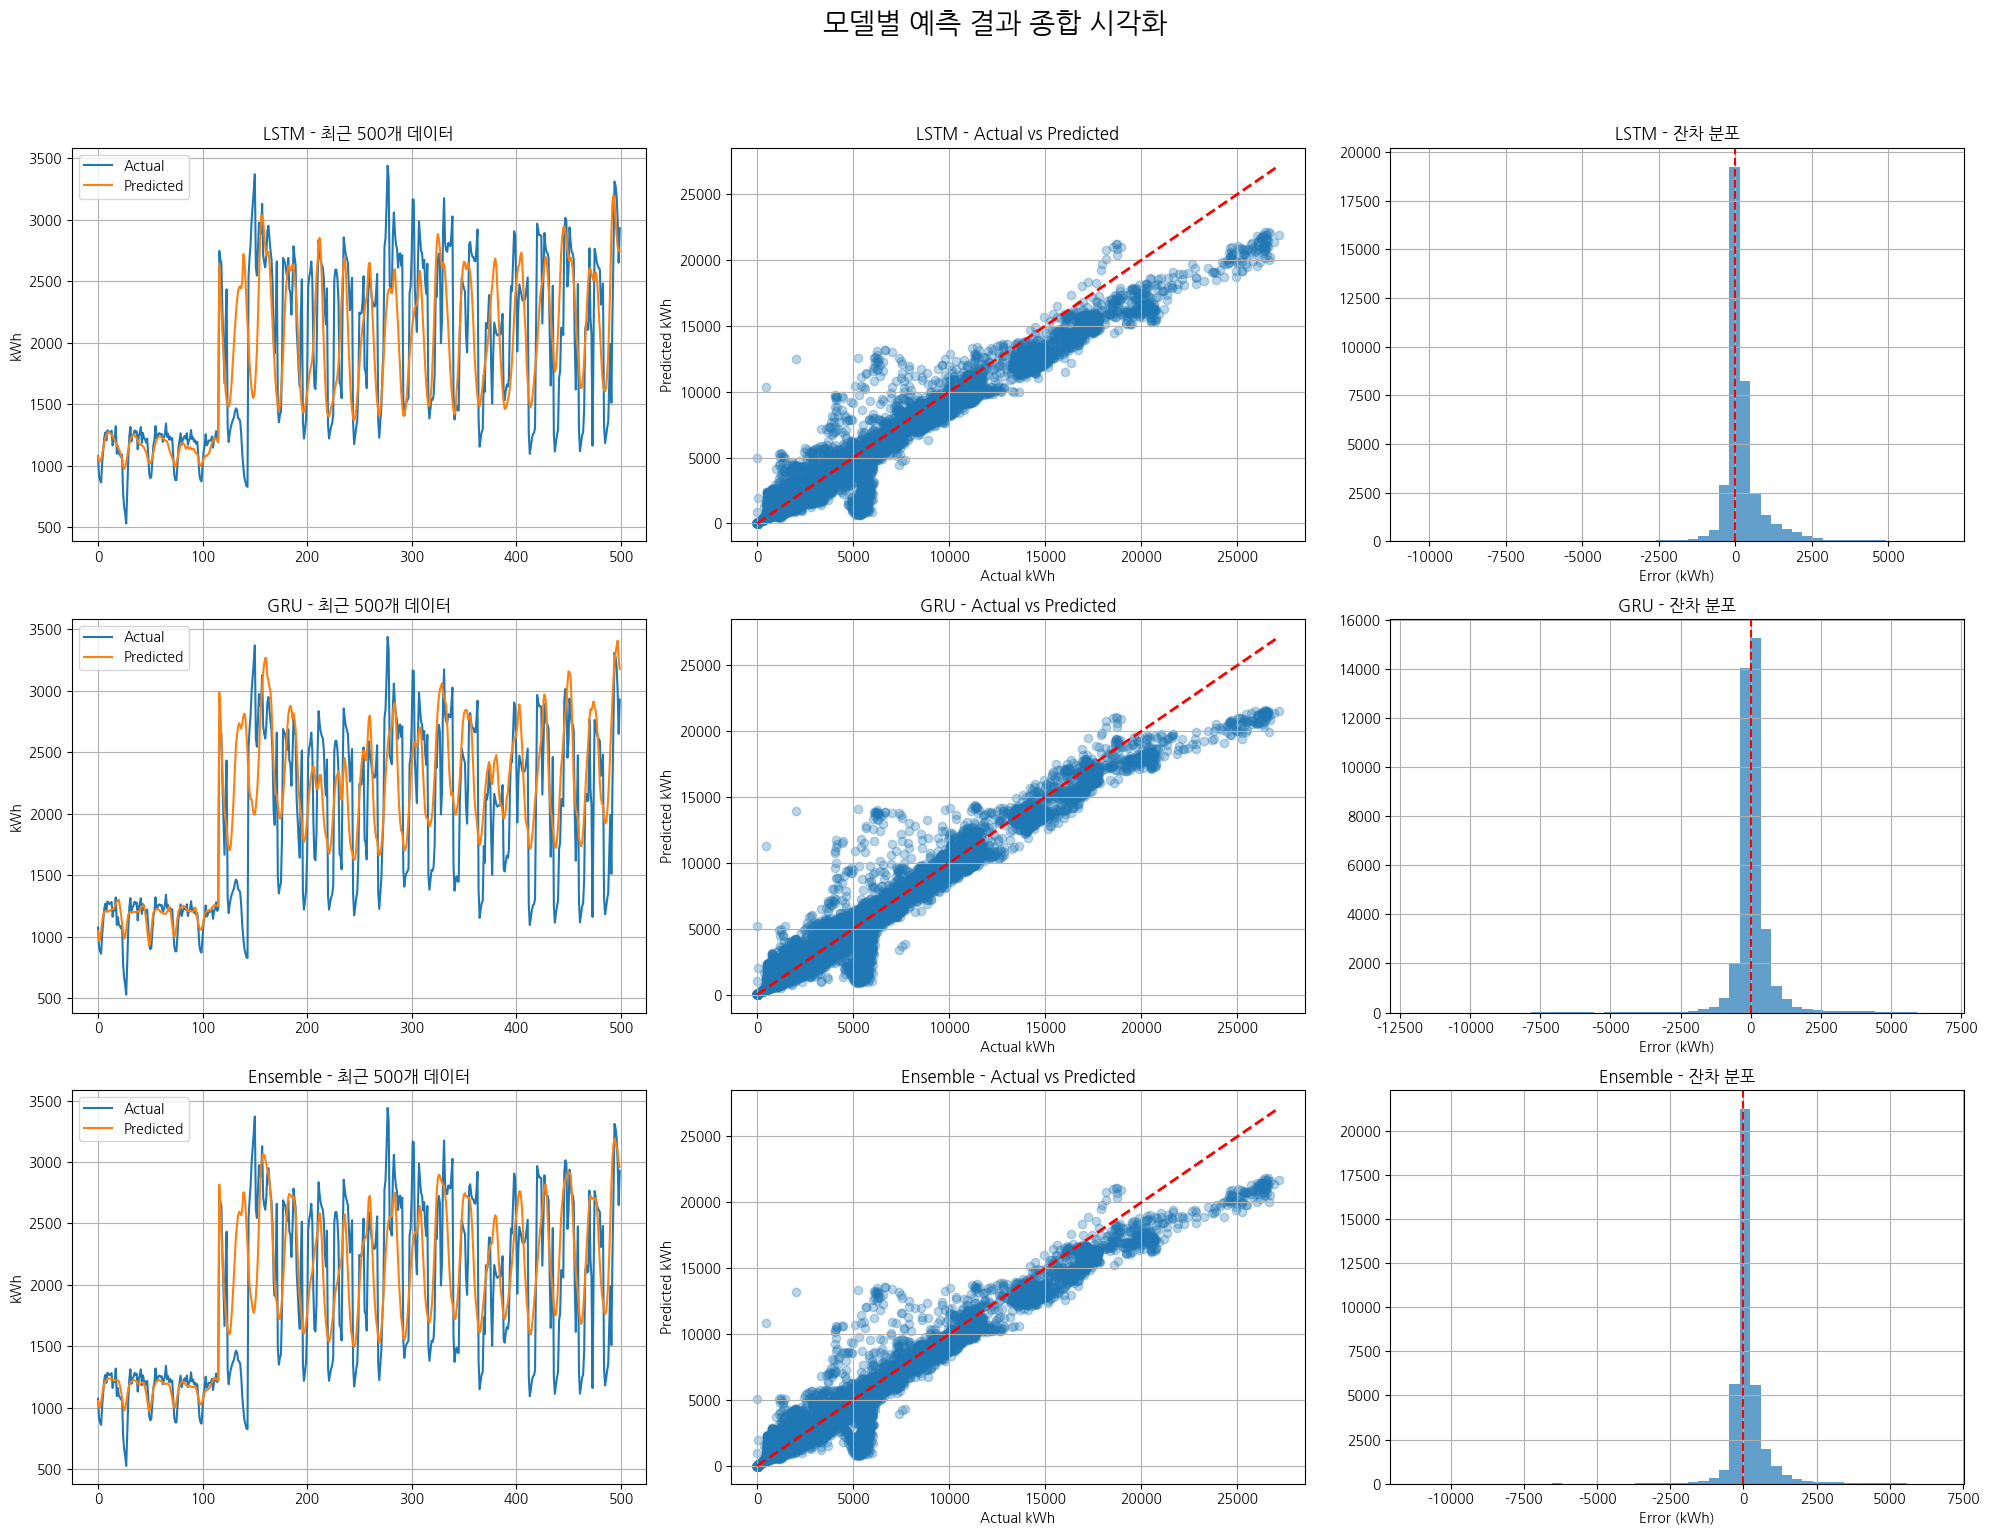

In [42]:
def plot_all_results(ax_row, title, y_true, y_pred):
    n = min(500, len(y_true))
    residuals = y_true - y_pred

    ax_row[0].plot(y_true[-n:], label='Actual')
    ax_row[0].plot(y_pred[-n:], label='Predicted')
    ax_row[0].set_title(f'{title} - 최근 {n}개 데이터')
    ax_row[0].set_ylabel('kWh')
    ax_row[0].legend()
    ax_row[0].grid(True)

    ax_row[1].scatter(y_true, y_pred, alpha=0.3)
    ax_row[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    ax_row[1].set_title(f'{title} - Actual vs Predicted')
    ax_row[1].set_xlabel('Actual kWh')
    ax_row[1].set_ylabel('Predicted kWh')
    ax_row[1].grid(True)

    ax_row[2].hist(residuals, bins=50, alpha=0.7)
    ax_row[2].axvline(0, color='red', linestyle='--')
    ax_row[2].set_title(f'{title} - 잔차 분포')
    ax_row[2].set_xlabel('Error (kWh)')
    ax_row[2].grid(True)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('모델별 예측 결과 종합 시각화', fontsize=20, y=1.02)

plot_all_results(axes[0], 'LSTM', y_va_true, y_va_pred_lstm)
plot_all_results(axes[1], 'GRU', y_va_true, y_va_pred_gru)
plot_all_results(axes[2], 'Ensemble', y_va_true, y_va_pred_ensemble)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()